# Spectral Fly Fishing
## Thomas Cycyota

### Notebook 2: Spectral Clustering
Manually implementing Isomap algorithm to differentiate fly patterns

In [149]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import kneighbors_graph 
import networkx as nx
import scipy.sparse.linalg as ll
%matplotlib inline

In [111]:
folder_prefix = "final_data/"

## Step 1: Load and prepare data

In [161]:
images = np.loadtxt(folder_prefix+"images_grey_final.txt", dtype='uint8', delimiter=',')

In [114]:
print("Greyscale shape:", images.shape)

Greyscale shape: (459, 4096)


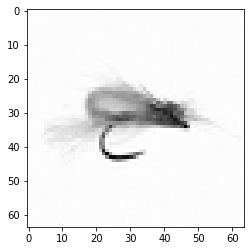

In [119]:
image_grey = images[457,:]
plot_grey = np.reshape(image_grey, (64,64)).astype('uint8')
plot_grey.shape
plt.imshow(plot_grey,cmap='gray');

## Step 2: Build matrix A
We will select each fly's 25 nearest neighbors to limit computational complexity but still provide a good sample size for each fly. Note that 25/459 ~ 5% of total flies in the sample size.

In [123]:
neighbors = 25
W = kneighbors_graph(images, neighbors, mode='distance', metric='euclidean', include_self=False)

In [121]:
W_d = W.todense()
A_d = W_d.copy()
A_d[A_d>0] = 1
A_d[A_d==0] = 999999

In [134]:
#Check correcness in partitions:
partitions = np.argpartition(A_d, kth=neighbors)
partitions[0,24:26]

matrix([[454, 311]])

In [135]:
# This value should be 1
A_d[0,454]

1.0

In [136]:
# This value should be >> 1
A_d[0,311]

999999.0

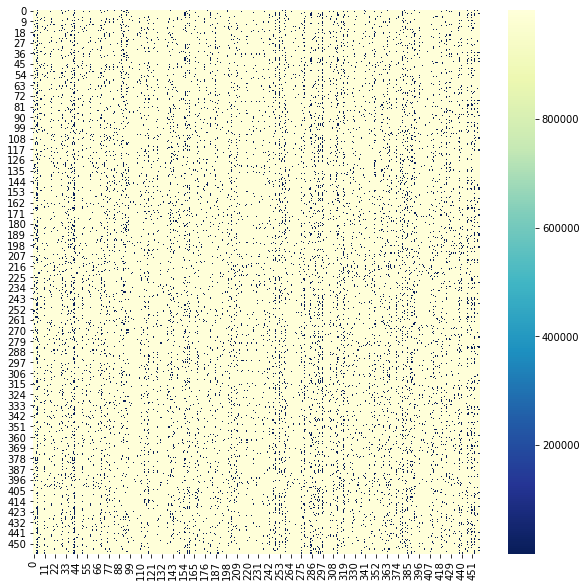

In [138]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(A_d,cmap="YlGnBu_r")

## Step 3: Plot relationship graph 

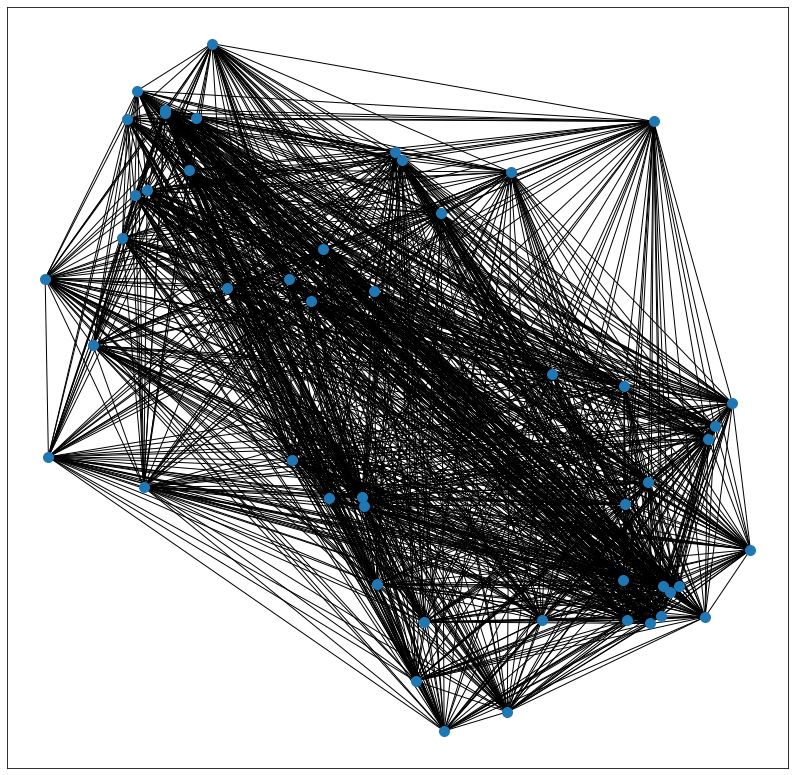

In [143]:
#Reset A Graph after previous changes
A_reset = A_d.copy()
A_reset[A_reset==999] = 0
#Pull out subset for Graph plotting
A_subset = A_reset[0:50, 0:50]
G_subset = nx.from_numpy_matrix(A_subset)
plt.figure(figsize=(14,14))
nx.draw_networkx(G_subset, node_size = 100, with_labels=False, widths=.05)

## Step 4: Build Matrix D from W

In [144]:
def Matrix_D(W):
    # Generate Graph and Obtain Matrix D, \\
    # from weight matrix W defining the weight on the edge between each pair of nodes.
    # Note that you can assign sufficiently large weights to non-existing edges.

    n = np.shape(W)[0]
    Graph = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            Graph.add_weighted_edges_from([(i,j,min(W[i,j], W[j,i]))])

    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
    # np.savetxt('D.csv', D)
    return D

In [146]:
W_d[W_d==0] = 999999
D = Matrix_D(W_d)

In [147]:
D

array([[   0.        , 4142.97163944, 3125.6242246 , ..., 3902.24023882,
        1821.16638449, 3234.21070346],
       [4142.97163944,    0.        , 3608.26189579, ..., 5427.04934261,
        4510.12304184, 4042.77889795],
       [3125.6242246 , 3608.26189579,    0.        , ..., 3684.49909302,
        3009.46331681, 3055.08987731],
       ...,
       [3902.24023882, 5427.04934261, 3684.49909302, ...,    0.        ,
        3786.07933103, 2143.80899336],
       [1821.16638449, 4510.12304184, 3009.46331681, ..., 3786.07933103,
           0.        , 2923.4717713 ],
       [3234.21070346, 4042.77889795, 3055.08987731, ..., 2143.80899336,
        2923.4717713 ,    0.        ]])

In [150]:
m = D.shape[0]
print("Shape of m:", m)

Shape of m: 459


## Step 5: Decomponse to H and C matrices 

In [151]:
H = np.identity(m)-(1/m)*np.ones((m,m))
C = 1/(2*m)* H @ np.square(D) @ H   

In [152]:
C = 1/2*(C+C.T)
print("This value should be ZERO if done correctly:", np.linalg.norm(C-C.T))

This value should be ZERO if done correctly: 0.0


In [153]:
S,W = ll.eigs(C,k=2)
w = W[:,:].real
s = S.real
Z = np.dot(w, np.diag(np.sqrt(abs(s))))

## Step 6: Plot Isomap

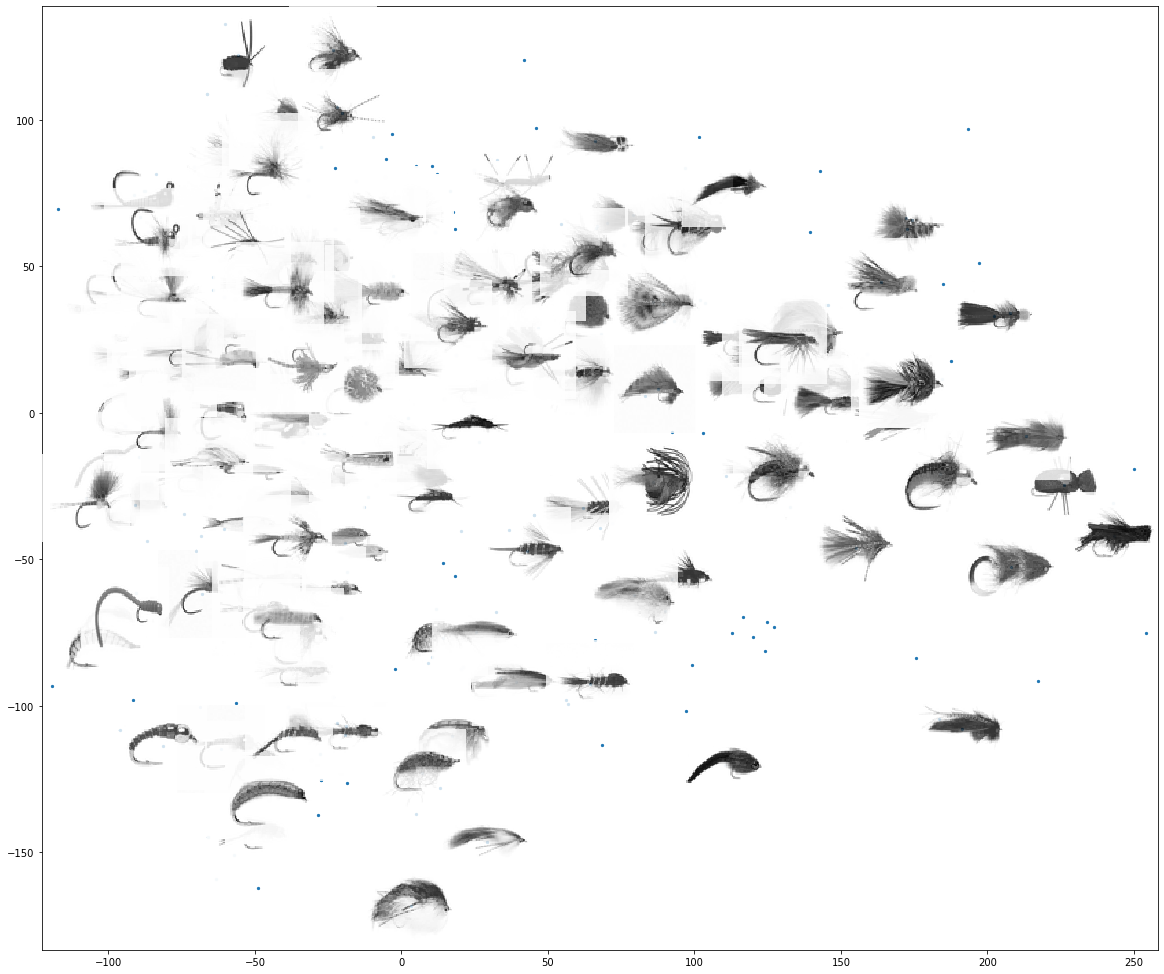

In [194]:
fig = plt.figure()
fig.set_size_inches(20, 20)
ax = fig.add_subplot(111)
# Show random images
sz = 30
m = images.shape[0]
num_to_show = 200
for i in range(num_to_show):
    img_num = np.random.randint(0, m)
    x_l = Z[img_num, 0] - (sz / 2.)
    x_r = Z[img_num, 0] + (sz / 2.)
    y_b = Z[img_num, 1] - (sz / 2.)
    y_t = Z[img_num, 1] + (sz / 2.)
    image= np.reshape(images[img_num,:], (64,64)).astype('uint8')
    ax.imshow(image, cmap='gray', zorder=100, extent=(x_l, x_r, y_b, y_t), alpha=.8)
# Show embeddings
ax.scatter(Z[:,0], Z[:,1], s=5)
plt.show()

## Step 7: Plot extreme images on both x and y axis of Isomap

In [225]:
def plot_extremes(selected):
    fig = plt.figure(figsize=(10,10))
    col = 5
    rows = 1
    for i in range(1, col*rows+1):
        img_num = selected[i]
        image = np.reshape(images[img_num,:], (64,64)).astype('uint8')
        fig.add_subplot(rows, col, i)
        plt.imshow(image,cmap='gray')
        plt.axis('off')
    plt.show();

#### X Axis min and max 

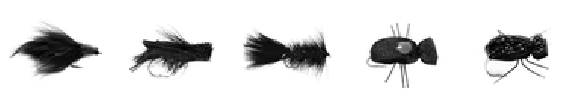

In [226]:
x_max = Z[:,0].argsort()[-6:][::-1].tolist()
plot_extremes(x_max)

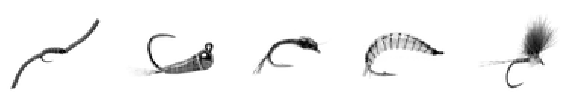

In [227]:
x_min = Z[:,0].argsort()[:8][::-1].tolist()
plot_extremes(x_min)

#### Y Axis min and max 

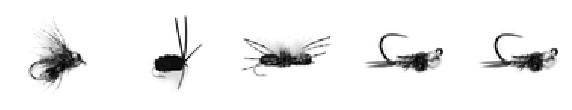

In [228]:
y_max = Z[:,1].argsort()[-6:][::-1].tolist()
plot_extremes(y_max)

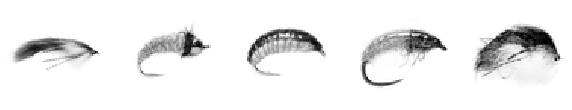

In [230]:
y_min = Z[:,1].argsort()[:6][::-1].tolist()
plot_extremes(y_min)